# **Rwanda/DRC flooding - working code**

In [1]:
import sys; sys.path.append('/home/clair/wwa')
from wwa import *

---
## **Data pre-processing**

Datasets used:
- MSWEP: https://www.gloh2o.org/mswep/
- TAMSAT: http://www.tamsat.org.uk/
- CHIRPS: https://data.chc.ucsb.edu/products/CHIRPS-2.0/global_daily/netcdf/p05/
- CPC: https://psl.noaa.gov/data/gridded/data.cpc.globalprecip.html
- ERA5: https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-single-levels?tab=overview

### **MSWEP**



In [9]:
# too much data to read & save in one go - save each year individually
for y in range(1979, 2021):
    
    ds = xr.open_mfdataset("/home/clair/Data/mswep_past/"+str(y)+"*.nc").sel(lon = slice(26,33), lat = slice(5,-6)).rename(precipitation = "precip")
    ds.to_netcdf("data/mswep_daily_26_33_-6_5_"+str(y)+".nc")

In [10]:
for y in range(2020, 2024):
    
    ds = xr.open_mfdataset("/home/clair/Data/mswep_nrt/"+str(y)+"*.nc").sel(lon = slice(26,33), lat = slice(5,-6)).rename(precipitation = "precip")
    ds.to_netcdf("data/mswep_daily_26_33_-6_5_"+str(y)+".nc")

### **CPC**

In [ ]:
cpc = xr.open_mfdataset("/home/clair/Data/cpc/precip.*.nc").sel(lon = slice(26,33), lat = slice(5,-6))
cpc.to_netcdf("data/cpc_daily_26_33_-6_5.nc")

### **CHIRPS**

In [3]:
chirps = xr.open_mfdataset("/home/clair/Data/chirps_05/*.nc").sel(longitude = slice(26,33), latitude = slice(-6,5)).rename(latitude = "lat", longitude = "lon")
chirps.to_netcdf("data/chirps_daily_26_33_-6_5.nc")

### **ERA5**

In [2]:
era5 = xr.open_dataset("data/adaptor.mars.internal-1684418312.343019-18895-7-0711ce56-0eb0-431e-85fb-af50dcdbf222.nc").tp
era5 = convert_units_to(era5.resample(time = "D").sum(), "mm").rename("precip", latitude = "lat", longitude = "lon")
era5.to_netcdf("data/era5_daily_26_33_-6_5.nc")

---
## **Local geography**

- DRC: South Kivu province mentioned in trigger, along with Kahele & Nyamukubi
- Rwanda: separate trigger
- no trigger for Burundi/Uganda/Tanzania but may be part of same precipitation event?  
&nbsp;
- administrative shapefile data downloaded from https://data.humdata.org/
- elevation data from http://research.jisao.washington.edu/data_sets/elevation/
- river basin shapefiles from https://www.hydrosheds.org/products/hydrobasins



In [84]:
# load gridded elevation data
elev = xr.open_dataset("../90_data/tbase_elev-0.25deg.nc").elev.sel(lon = slice(20,40), lat = slice(-15,10))

# load administrative shapefiles
drc = gpd.read_file("sf/drc-adm1").set_index("ADM1_FR")
sk = drc.loc[["Sud-Kivu"]]

ug = gpd.read_file("sf/uganda-adm1").set_index("ADM1_EN")
ugw = ug.loc[["Western"]]

rw = gpd.read_file("sf/rwanda-adm0")
bu = gpd.read_file("sf/burundi-adm0")

# get lat-lon coordinates of named locations; also define location of country labels
px = {k : get_latlon(k).values() for k in ["Kalehe", "Nyamukubi", "Goma", "Bushushu"]}
adm_labels = {"Uganda" : [30.8, 2], "DRC" : [23, -1], "Rwanda" : [31, -2], "Burundi" : [31,-3.4], "Tanzania" : [32.5, -6.5]}

# load shapefile for river basin & clip to required extent
hb05 = gpd.read_file("sf/hybas-lev05").clip([26,-6,33,5])

/home/clair/miniconda3/envs/wwa/lib/python3.10/site-packages/geopandas/tools/clip.py:63: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[


In [18]:
# create combined shapefile to plot area of (provisional) interest
sf = pd.concat([drc.loc[["Sud-Kivu", "Nord-Kivu"]], rw, bu, ugw]).clip([26,-6,33,1]).dissolve().explode()
sf = sf.loc[[a == sf.geometry.area.max() for a in sf.geometry.area]]
sf.geometry = sf.exterior.geometry.apply(lambda x: Polygon(x.coords))
sf.to_file("sf_provisional")

/home/clair/miniconda3/envs/wwa/lib/python3.10/site-packages/geopandas/tools/clip.py:63: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[
/tmp/ipykernel_7167/1837527137.py:2: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf = pd.concat([drc.loc[["Sud-Kivu", "Nord-Kivu"]], rw, bu, ugw]).clip([26,-6,33,1]).dissolve().explode()
/tmp/ipykernel_7167/1837527137.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  sf = sf.loc[[a == sf.geometry.area.max() for

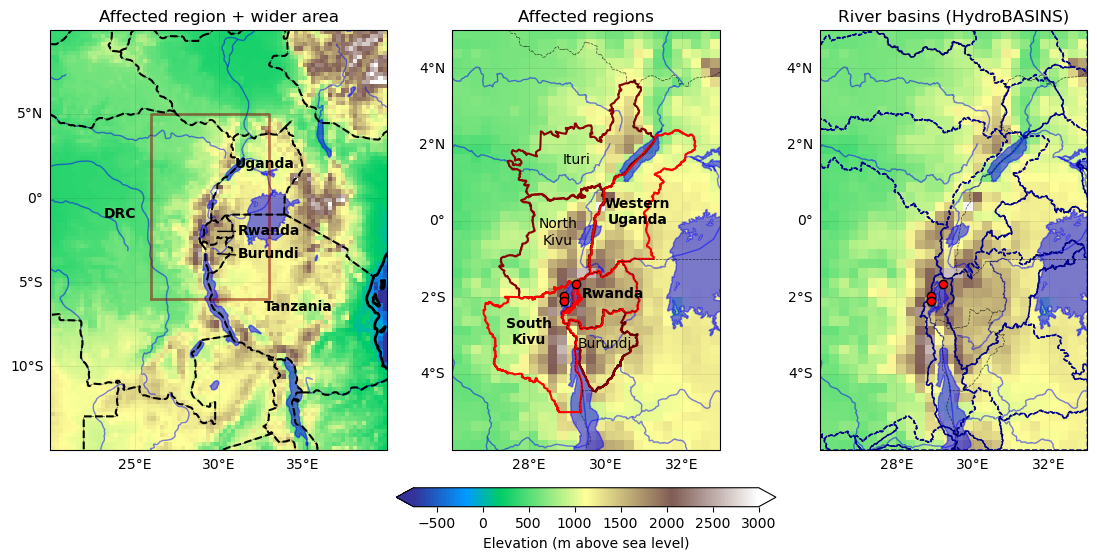

In [96]:
fig, axs = plt.subplots(ncols = 3, figsize = (14,7), dpi = 100, subplot_kw = {"projection" : cartopy.crs.PlateCarree()})
plt.subplots_adjust(wspace = 0.05)

elev_kwargs = {"cmap" : "terrain", "vmin" : -750, "vmax" : 3000, "add_colorbar" : False}

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ax = axs[0]
cbar = elev.plot(ax = ax, **elev_kwargs)

ax.gridlines(crs=cartopy.crs.PlateCarree(), linewidth=0.5, color='black', draw_labels=["left", "bottom"], alpha=0.1, xlocs = np.arange(20,40,5))
ax.set_title("Affected region + wider area")

ax.plot([26,26,33,33,26], [-6,5,5,-6,-6], color = "darkred", lw = 2, alpha = 0.5)
ax.add_feature(cartopy.feature.BORDERS, lw = 1.5, ls = "--", zorder = 99)

[ax.annotate(k, xy = v, fontweight = "bold", textcoords="offset points", xytext=(2,-2), ha='left') for k, v in adm_labels.items()]
ax.plot([rw.geometry.centroid.x[0], adm_labels["Rwanda"][0]], [rw.geometry.centroid.y[0], adm_labels["Rwanda"][1]], color = "k", lw = 1)
ax.plot([bu.geometry.centroid.x[0], adm_labels["Burundi"][0]], [bu.geometry.centroid.y[0], adm_labels["Burundi"][1]], color = "k", lw = 1)

# pd.concat([rw, bu, ugw, drc.loc[["Sud-Kivu", "Nord-Kivu", "Ituri"]]]).explode(index_parts = True).dissolve().boundary.plot(ax = ax)

# rectangle(26,33,-6,5, ax = ax, color = "k", alpha = 0.1)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ax = axs[1]
elev.sel(lon = slice(26,33), lat = slice(-6,5)).plot(ax = ax, **elev_kwargs)
ax.gridlines(crs=cartopy.crs.PlateCarree(), linewidth=0.5, color='black', draw_labels=["bottom", "left"], alpha=0.1, xlocs = np.arange(20,40,2), ylocs = range(-6,6,2))
ax.set_title("Affected regions")

bu.boundary.plot(ax = ax, color = "darkred")
drc.loc[["Nord-Kivu", "Ituri"]].boundary.plot(ax = ax, color = "darkred")

sk.boundary.plot(ax = ax, color = "red")
rw.boundary.plot(ax = ax, color = "red")
ugw.boundary.plot(ax = ax, color = "red")

[ax.scatter(*xy, marker = "o", color = "red", edgecolor = "k", zorder = 999) for xy in px.values()]

ax.annotate("South\nKivu", xy = (sk.geometry.centroid.x-0.25, sk.geometry.centroid.y), ha = "center", fontweight = "bold")
ax.annotate("Rwanda", xy = (rw.geometry.centroid.x+0.25, rw.geometry.centroid.y), ha = "center", fontweight = "bold")
ax.annotate("Western\nUganda", xy = (ugw.geometry.centroid.x+0.1, ugw.geometry.centroid.y-0.5), ha = "center", fontweight = "bold")

ax.annotate("North\nKivu", xy = (drc.loc["Nord-Kivu"].geometry.centroid.x+0.05, drc.loc["Nord-Kivu"].geometry.centroid.y), ha = "center")
ax.annotate("Ituri", xy = (drc.loc["Ituri"].geometry.centroid.x-0.25, drc.loc["Ituri"].geometry.centroid.y-0.25), ha = "center")
ax.annotate("Burundi", xy = (bu.geometry.centroid.x+0.05, bu.geometry.centroid.y), ha = "center")

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ax = axs[2]
elev.sel(lon = slice(26,33), lat = slice(-6,5)).plot(ax = ax, **elev_kwargs)
ax.gridlines(crs=cartopy.crs.PlateCarree(), linewidth=0.5, color='black', draw_labels=["bottom", "left"], alpha=0.1, xlocs = np.arange(20,40,2), ylocs = range(-6,6,2))
ax.set_title("River basins (HydroBASINS)")

hb05.boundary.plot(ax = ax, color = "darkblue", lw = 1, ls = "--")
[ax.scatter(*xy, marker = "o", color = "red", edgecolor = "k", zorder = 999) for xy in px.values()]

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
for ax in axs:

    ax.coastlines(lw = 2)
    ax.add_feature(cartopy.feature.BORDERS, lw = 0.5, alpha = 0.7, ls = "--", zorder = 99)

    ax.add_feature(cartopy.feature.RIVERS, color = "blue", alpha = 0.5)
    ax.add_feature(cartopy.feature.LAKES, color = "blue", alpha = 0.5)
    
plt.colorbar(cbar, ax = axs, location = "bottom", extend = "both", shrink = 0.35, pad = 0.07, label = "Elevation (m above sea level)")

plt.savefig("fig/physical-geography.png")

---
## **Gridded datasets**

_Checked on May 17th: CHIRPS not yet updated_

### **Maps of the event**

In [4]:
mswep = xr.open_mfdataset("/home/clair/Data/mswep_nrt/2023*.nc").sel(lon = slice(26,33), lat = slice(5,-6), time = "2023-05").precipitation.load()
cpc = xr.open_mfdataset("/home/clair/Data/cpc/precip.2023.nc").sel(lon = slice(26,33), lat = slice(5,-6), time = "2023-05").precip.load()
tamsat = xr.open_dataset("data/01-tamsatDaily.v3.1-1682895600-1688166000_26.0_33.0_-6.0_5.0.nc").rfe_filled.load()
era5 = xr.open_dataset("data/era5_daily_26_33_-6_5.nc").precip

sf = gpd.read_file("sf_provisional")

In [6]:
plot_kwargs = {"cmap" : "YlGnBu", "vmin" : 0, "add_colorbar" : False}

for i in range(4):
    da_name = ["MSWEP", "CPC", "TAMSAT", "ERA5"][i]
    da = eval(da_name.lower())
    vmax = 110
    
    fig, axs = plt.subplots(ncols = 4, figsize = (10,5), dpi = 100, subplot_kw = {"projection" : cartopy.crs.PlateCarree()})
    plt.subplots_adjust(wspace = 0.05)
    plt.suptitle(da_name, fontsize='x-large', fontweight = "bold")
    
    for j in range(4):
        ax = axs[j]
        cbar = da.sel(time = "2023-05-0"+str(j+1)).plot(ax = ax, vmax = vmax, **plot_kwargs)
        sf.boundary.plot(ax = ax, color = "darkred")
        ax.add_feature(cartopy.feature.LAKES, color = "blue", alpha = 0.2)
        ax.add_feature(cartopy.feature.RIVERS, color = "blue", alpha = 0.2)
        ax.gridlines(crs=cartopy.crs.PlateCarree(), linewidth=0.5, color='black', draw_labels=["bottom"], alpha=0.1, xlocs = np.arange(20,40,2), ylocs = range(-6,6,2))
    axs[0].gridlines(crs=cartopy.crs.PlateCarree(), linewidth=0.5, color='black', draw_labels=["left"], alpha=0.1, xlocs = np.arange(20,40,2), ylocs = range(-6,6,2))
    plt.colorbar(cbar, ax = axs, location = "bottom", shrink = 0.35, pad = 0.1, label = "Precipitation (mm/day)")
    
    plt.savefig("fig/may-precip_"+da_name.lower()+".png"); plt.close()

### **Time series**

In [7]:
mswep = xr.open_mfdataset("data/mswep_daily_26_33_-6_5_*.nc").precip.load()
cpc = xr.open_dataset("data/cpc_daily_26_33_-6_5.nc").precip
tamsat = xr.open_dataset("data/01-tamsatDaily.v3.1-1682895600-1688166000_26.0_33.0_-6.0_5.0.nc").rfe_filled.load().dropna("time", "all")
chirps = xr.open_dataset("data/chirps_daily_26_33_-6_5.nc").precip.dropna("time", "all")
era5 = xr.open_dataset("data/era5_daily_26_33_-6_5.nc").precip

sf = gpd.read_file("sf_provisional")

#### **Time series over provisional region**

In [8]:
mswep_prov, cpc_prov, chirps_prov, tamsat_prov, era5_prov = [da.where(regionmask.mask_3D_geopandas(sf, da.lon, da.lat).squeeze(drop = True) == 1).mean(["lat", "lon"]) for da in [mswep, cpc, chirps, tamsat, era5]]

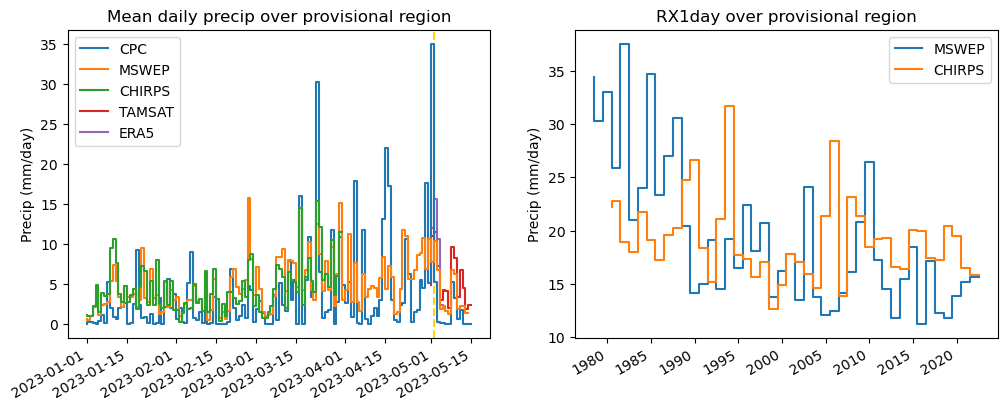

In [14]:
fig, axs = plt.subplots(ncols = 2, figsize = (12,4), dpi = 100)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

cpc_prov.sel(time = "2023").plot(ax = axs[0], label = "CPC", drawstyle = "steps")
mswep_prov.sel(time = "2023").plot(ax = axs[0], label = "MSWEP", drawstyle = "steps")
chirps_prov.sel(time = "2023").plot(ax = axs[0], label = "CHIRPS", drawstyle = "steps")
tamsat_prov.sel(time = "2023").plot(ax = axs[0], label = "TAMSAT", drawstyle = "steps", zorder = -9)
era5_prov.sel(time = "2023").plot(ax = axs[0], label = "ERA5", drawstyle = "steps", zorder = -9)

axs[0].set_title("Mean daily precip over provisional region")
axs[0].axvline(np.datetime64("2023-05-02"), ls = "--", color = "gold", zorder = -99)
axs[0].legend()

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

mswep_prov.resample(time = "AS-JUL").max().plot(label = "MSWEP", drawstyle = "steps")
chirps_prov.resample(time = "AS-JUL").max().plot(label = "CHIRPS", drawstyle = "steps")
# tamsat_prov.resample(time = "AS-JUL").max().plot(label = "TAMSAT", drawstyle = "steps")

axs[1].legend()
axs[1].set_title("RX1day over provisional region")

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

for ax in axs:
    ax.set_xlabel("")
    ax.set_ylabel("Precip (mm/day)")

plt.savefig("fig/provisional-region_timeseries.png")

#### **Time series over Lake Kivu only**

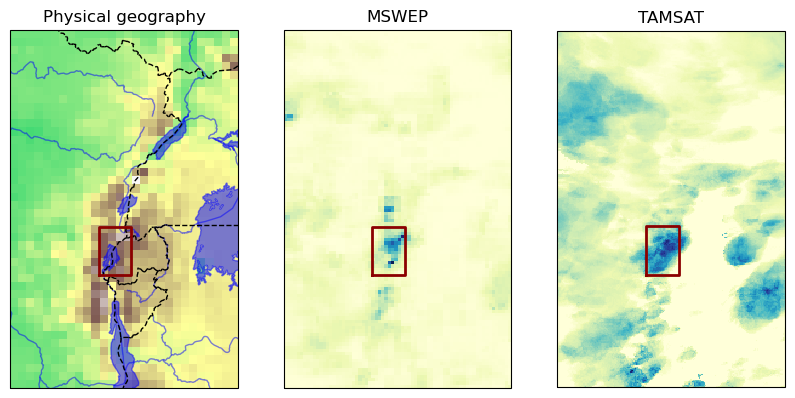

In [16]:
# small box centred on Lake Kivu
elev = xr.open_dataset("../90_data/tbase_elev-0.25deg.nc").elev.sel(lon = slice(20,40), lat = slice(-15,10))
elev_kwargs = {"cmap" : "terrain", "vmin" : -750, "vmax" : 3000, "add_colorbar" : False}
lk = get_latlon("Lake Kivu")

fig, axs = plt.subplots(ncols = 3, figsize = (10,5), dpi = 100, subplot_kw = {"projection" : cartopy.crs.PlateCarree()})
elev.sel(lon = slice(26,33), lat = slice(-6,5)).plot(ax = axs[0], **elev_kwargs)
axs[0].set_title("Physical geography")
axs[0].add_feature(cartopy.feature.LAKES, color = "blue", alpha = 0.5)
axs[0].add_feature(cartopy.feature.RIVERS, color = "blue", alpha = 0.5)
axs[0].add_feature(cartopy.feature.BORDERS, color = "k", ls = "--")
    
mswep.sel(time = "2023-05-02").plot(ax = axs[1], cmap = "YlGnBu", add_colorbar = False)
axs[1].set_title("MSWEP")

tamsat.sel(time = "2023-05-02").plot(ax = axs[2], cmap = "YlGnBu", add_colorbar = False)
axs[2].set_title("TAMSAT")

x0 = -0.5; x1 = 0.5; y0 = -0.5; y1 = 1

for ax in axs:

    ax.plot([lk["lon"] + x_adj for x_adj in [x0,x0,x1,x1,x0]], [lk["lat"] + y_adj for y_adj in [y0,y1,y1,y0,y0]], color = "darkred", lw = 2)
    
plt.savefig("fig/lake-kivu_region.png")

In [20]:
mswep_lk = mswep.sel(lon = slice(lk["lon"]+x0, lk["lon"]+x1), lat = slice(lk["lat"]+y1, lk["lat"]+y0)).mean(["lat", "lon"])      # latitudes reversed
tamsat_lk = tamsat.sel(lon = slice(lk["lon"]+x0, lk["lon"]+x1), lat = slice(lk["lat"]+y1, lk["lat"]+y0)).mean(["lat", "lon"])    # latitudes reversed
chirps_lk = chirps.sel(lon = slice(lk["lon"]+x0, lk["lon"]+x1), lat = slice(lk["lat"]+y0, lk["lat"]+y1)).mean(["lat", "lon"])
era5_lk = era5.sel(lon = slice(lk["lon"]+x0, lk["lon"]+x1), lat = slice(lk["lat"]+y1, lk["lat"]+y0)).mean(["lat", "lon"])

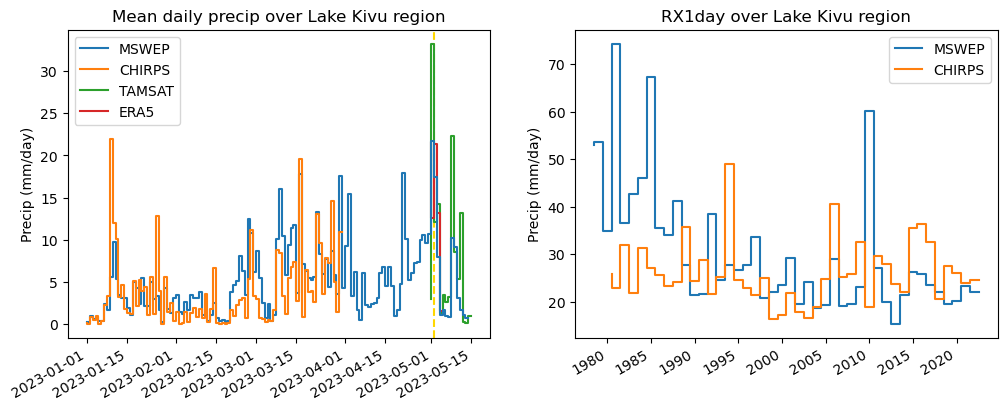

In [21]:
fig, axs = plt.subplots(ncols = 2, figsize = (12,4), dpi = 100)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

mswep_lk.sel(time = "2023").plot(ax = axs[0], label = "MSWEP", drawstyle = "steps")
chirps_lk.sel(time = "2023").plot(ax = axs[0], label = "CHIRPS", drawstyle = "steps")
tamsat_lk.sel(time = "2023").plot(ax = axs[0], label = "TAMSAT", drawstyle = "steps", zorder = -9)
era5_lk.sel(time = "2023").plot(ax = axs[0], label = "ERA5", drawstyle = "steps", zorder = -9)

axs[0].set_title("Mean daily precip over Lake Kivu region")
axs[0].axvline(np.datetime64("2023-05-02"), ls = "--", color = "gold", zorder = -99)
axs[0].legend()

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

mswep_lk.resample(time = "AS-JUL").max().plot(label = "MSWEP", drawstyle = "steps")
chirps_lk.resample(time = "AS-JUL").max().plot(label = "CHIRPS", drawstyle = "steps")
# tamsat_lk.resample(time = "AS-JUL").max().plot(label = "TAMSAT", drawstyle = "steps")

axs[1].legend()
axs[1].set_title("RX1day over Lake Kivu region")


#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

for ax in axs:
    ax.set_xlabel("")
    ax.set_ylabel("Precip (mm/day)")

plt.savefig("fig/lake-kivu_timeseries.png")

---
## **Station data**

### **Map of station locations**

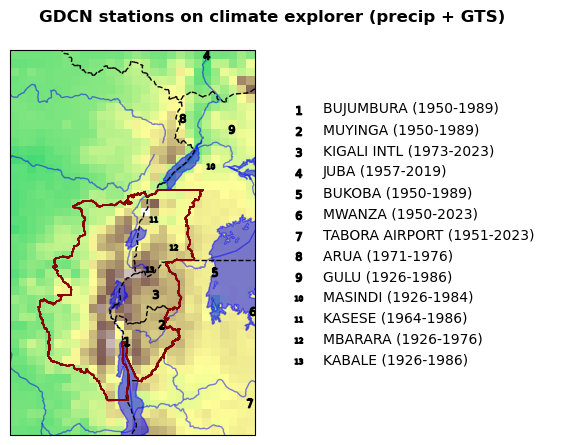

In [22]:
elev = xr.open_dataset("../90_data/tbase_elev-0.25deg.nc").elev.sel(lon = slice(20,40), lat = slice(-15,10))
elev_kwargs = {"cmap" : "terrain", "vmin" : -750, "vmax" : 3000, "add_colorbar" : False}
sf = gpd.read_file("sf_provisional")

fig, axs = plt.subplots(ncols = 2, figsize = (7,5), dpi = 100, subplot_kw = {"projection" : cartopy.crs.PlateCarree()})
ax = axs[0]
elev.sel(lon = slice(26,33), lat = slice(-6,5)).plot(ax = ax, **elev_kwargs)

ax.add_feature(cartopy.feature.LAKES, color = "blue", alpha = 0.5)
ax.add_feature(cartopy.feature.RIVERS, color = "blue", alpha = 0.5)
ax.add_feature(cartopy.feature.BORDERS, color = "k", ls = "--")

fl = sorted(glob.glob("data/pgdcngts*.nc"))
for i in range(len(fl)):
    
    fnm = fl[i]
    da = xr.open_dataset(fnm)
    
    lat = float(da.latitude.strip().split(" ")[0])
    lon = float(da.longitude.strip().split(" ")[0])
    stn = da.description + " ("+"-".join([str(d) for d in da.isel(time = [0,-1]).time.dt.year.values])+")"
    
    ax.scatter(lon, lat, marker = "$"+str(i+1)+"$", color = "k", label = stn, zorder = 99)
    sf.boundary.plot(ax = ax, color = "darkred", lw = 1)
    
axs[1].set_axis_off()
fig.legend(bbox_to_anchor = (0.5,0.8), loc = "upper left", edgecolor = "w")
plt.suptitle("GDCN stations on climate explorer (precip + GTS)", fontweight = "bold", y = 0.96)
plt.savefig("fig/gdcn-station-locations.png")